In [1]:
import shutil
import os

source = "C:/ExamCheatingDataset"
target = "./ExamCheatingDataset"  

if not os.path.exists(target):
    shutil.copytree(source, target)
    print(" Dataset copied to project folder.")
else:
    print(" Dataset already exists in the project folder.")


 Dataset copied to project folder.


In [2]:
root = "./ExamCheatingDataset"


In [3]:
import os
os.listdir(root + "/train")

['cheating', 'giving code', 'giving object', 'looking friend', 'normal act']

In [4]:
print(os.listdir("ExamCheatingDataset"))
print(os.listdir("ExamCheatingDataset/train"))

['test', 'train']
['cheating', 'giving code', 'giving object', 'looking friend', 'normal act']


In [5]:
import os
print(os.listdir())


['ExamCheatingDataset', 'malpractices (4).ipynb']


In [6]:
!pip install --user torch torchvision torchaudio

In [7]:
!pip install torch torchvision

In [8]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms as T
from sklearn.utils.class_weight import compute_class_weight
from glob import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root, data_type=None, transformations=None):
        self.transformations = transformations
        self.data_type = data_type
        self.im_paths = glob(f"{root}/{data_type}/*/*.jpg") if data_type == "train" else glob(f"{root}/{data_type}/images/*.jpg")

        if self.data_type == "train":
            self.get_info()

    def get_info(self):
        self.cls_names, self.cls_counts, count = {}, {}, 0
        for im_path in self.im_paths:
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names:
                self.cls_names[class_name] = count
                self.cls_counts[class_name] = 1
                count += 1
            else:
                self.cls_counts[class_name] += 1

    def get_class(self, path):
        return os.path.basename(os.path.normpath(os.path.dirname(path))).lower().strip()

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):
        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[self.get_class(im_path)] if self.data_type == "train" else im_path
        if self.transformations:
            im = self.transformations(im)
        return im, gt

In [11]:
def get_dls(root, transformations, bs, split=[0.9, 0.1], ns=2):
    dataset = CustomDataset(root=root, data_type="train", transformations=transformations)
    ts_ds = CustomDataset(root=root, data_type="test", transformations=transformations)

    tr_len = int(len(dataset) * split[0])
    vl_len = len(dataset) - tr_len

    tr_ds, vl_ds = random_split(dataset, [tr_len, vl_len])

    tr_dl = DataLoader(tr_ds, batch_size=bs, shuffle=True, num_workers=0)
    val_dl = DataLoader(vl_ds, batch_size=bs, shuffle=False, num_workers=0)
    ts_dl = DataLoader(ts_ds, batch_size=1, shuffle=False, num_workers=0)

    return tr_dl, val_dl, ts_dl, dataset.cls_names

In [12]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=25):
    model.to(device)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_f1s, val_f1s = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0.0, 0, 0
        y_true, y_pred = [], []

        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

        train_acc = correct / total
        train_losses.append(total_loss)
        train_accuracies.append(train_acc)
        train_f1s.append(f1_score(y_true, y_pred, average='weighted'))

        print(f"Epoch {epoch+1}, Train Loss: {total_loss:.4f}, Accuracy: {train_acc:.4f}")

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        y_true_val, y_pred_val = [], []
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                preds = outputs.argmax(1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
                y_true_val.extend(labels.cpu().numpy())
                y_pred_val.extend(preds.cpu().numpy())

        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(f1_score(y_true_val, y_pred_val, average='weighted'))

        print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}\n")

 
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss per Epoch")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
    plt.plot(epochs_range, val_accuracies, label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy per Epoch")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, train_f1s, label="Train F1 Score")
    plt.plot(epochs_range, val_f1s, label="Val F1 Score")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title("F1 Score per Epoch")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [14]:
root = "ExamCheatingDataset"
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 64

transform = T.Compose([
    T.Resize((im_size, im_size)),
    T.ToTensor(),
    T.Normalize(mean, std)
])

tr_dl, val_dl, ts_dl, classes = get_dls(root=root, transformations=transform, bs=32)

print("Train Batches:", len(tr_dl))
print("Val Batches:", len(val_dl))
print("Test Batches:", len(ts_dl))
print("Classes:", classes)

Train Batches: 43
Val Batches: 5
Test Batches: 496
Classes: {'cheating': 0, 'giving code': 1, 'giving object': 2, 'looking friend': 3, 'normal act': 4}


Epoch 1/25 - Training: 100%|██████████| 43/43 [00:06<00:00,  6.68it/s]


Epoch 1, Train Loss: 56.5470, Accuracy: 0.6256
Epoch 1, Val Loss: 3.4081, Accuracy: 0.7616



Epoch 2/25 - Training: 100%|██████████| 43/43 [00:06<00:00,  6.67it/s]


Epoch 2, Train Loss: 25.2861, Accuracy: 0.8239
Epoch 2, Val Loss: 2.2492, Accuracy: 0.8344



Epoch 3/25 - Training: 100%|██████████| 43/43 [00:06<00:00,  6.88it/s]


Epoch 3, Train Loss: 13.0245, Accuracy: 0.8865
Epoch 3, Val Loss: 1.3544, Accuracy: 0.8940



Epoch 4/25 - Training: 100%|██████████| 43/43 [00:06<00:00,  6.85it/s]


Epoch 4, Train Loss: 7.8061, Accuracy: 0.9197
Epoch 4, Val Loss: 1.1516, Accuracy: 0.9007



Epoch 5/25 - Training: 100%|██████████| 43/43 [00:05<00:00,  7.21it/s]


Epoch 5, Train Loss: 5.8544, Accuracy: 0.9307
Epoch 5, Val Loss: 1.1540, Accuracy: 0.9139



Epoch 6/25 - Training: 100%|██████████| 43/43 [00:05<00:00,  7.52it/s]


Epoch 6, Train Loss: 4.8612, Accuracy: 0.9410
Epoch 6, Val Loss: 0.9001, Accuracy: 0.9139



Epoch 7/25 - Training: 100%|██████████| 43/43 [00:06<00:00,  6.62it/s]


Epoch 7, Train Loss: 3.5437, Accuracy: 0.9573
Epoch 7, Val Loss: 0.7280, Accuracy: 0.9404



Epoch 8/25 - Training: 100%|██████████| 43/43 [00:05<00:00,  7.55it/s]


Epoch 8, Train Loss: 2.9283, Accuracy: 0.9698
Epoch 8, Val Loss: 0.7135, Accuracy: 0.9404



Epoch 9/25 - Training: 100%|██████████| 43/43 [00:05<00:00,  7.35it/s]


Epoch 9, Train Loss: 2.6858, Accuracy: 0.9676
Epoch 9, Val Loss: 0.9088, Accuracy: 0.9536



Epoch 10/25 - Training: 100%|██████████| 43/43 [00:06<00:00,  7.14it/s]


Epoch 10, Train Loss: 2.3995, Accuracy: 0.9786
Epoch 10, Val Loss: 0.7074, Accuracy: 0.9470



Epoch 11/25 - Training: 100%|██████████| 43/43 [00:06<00:00,  6.41it/s]


Epoch 11, Train Loss: 2.6235, Accuracy: 0.9816
Epoch 11, Val Loss: 0.7279, Accuracy: 0.9536



Epoch 12/25 - Training: 100%|██████████| 43/43 [00:08<00:00,  5.12it/s]


Epoch 12, Train Loss: 2.6161, Accuracy: 0.9779
Epoch 12, Val Loss: 0.5801, Accuracy: 0.9669



Epoch 13/25 - Training: 100%|██████████| 43/43 [00:07<00:00,  5.91it/s]


Epoch 13, Train Loss: 2.5025, Accuracy: 0.9713
Epoch 13, Val Loss: 0.9164, Accuracy: 0.9470



Epoch 14/25 - Training: 100%|██████████| 43/43 [00:07<00:00,  5.40it/s]


Epoch 14, Train Loss: 1.8489, Accuracy: 0.9838
Epoch 14, Val Loss: 0.3770, Accuracy: 0.9735



Epoch 15/25 - Training: 100%|██████████| 43/43 [00:10<00:00,  3.96it/s]


Epoch 15, Train Loss: 1.1873, Accuracy: 0.9875
Epoch 15, Val Loss: 0.4656, Accuracy: 0.9669



Epoch 16/25 - Training: 100%|██████████| 43/43 [00:10<00:00,  3.92it/s]


Epoch 16, Train Loss: 1.2723, Accuracy: 0.9867
Epoch 16, Val Loss: 0.3224, Accuracy: 0.9801



Epoch 17/25 - Training: 100%|██████████| 43/43 [00:12<00:00,  3.52it/s]


Epoch 17, Train Loss: 0.9363, Accuracy: 0.9919
Epoch 17, Val Loss: 0.3311, Accuracy: 0.9669



Epoch 18/25 - Training: 100%|██████████| 43/43 [00:12<00:00,  3.53it/s]


Epoch 18, Train Loss: 1.1155, Accuracy: 0.9904
Epoch 18, Val Loss: 0.5381, Accuracy: 0.9603



Epoch 19/25 - Training: 100%|██████████| 43/43 [00:12<00:00,  3.45it/s]


Epoch 19, Train Loss: 0.9063, Accuracy: 0.9926
Epoch 19, Val Loss: 0.4051, Accuracy: 0.9735



Epoch 20/25 - Training: 100%|██████████| 43/43 [00:13<00:00,  3.16it/s]


Epoch 20, Train Loss: 1.6061, Accuracy: 0.9853
Epoch 20, Val Loss: 0.4501, Accuracy: 0.9669



Epoch 21/25 - Training: 100%|██████████| 43/43 [00:19<00:00,  2.18it/s]


Epoch 21, Train Loss: 1.6262, Accuracy: 0.9897
Epoch 21, Val Loss: 0.3314, Accuracy: 0.9868



Epoch 22/25 - Training: 100%|██████████| 43/43 [00:21<00:00,  1.99it/s]


Epoch 22, Train Loss: 1.0394, Accuracy: 0.9926
Epoch 22, Val Loss: 0.3217, Accuracy: 0.9735



Epoch 23/25 - Training: 100%|██████████| 43/43 [00:20<00:00,  2.14it/s]


Epoch 23, Train Loss: 0.6786, Accuracy: 0.9948
Epoch 23, Val Loss: 0.3513, Accuracy: 0.9735



Epoch 24/25 - Training: 100%|██████████| 43/43 [00:19<00:00,  2.24it/s]


Epoch 24, Train Loss: 0.8100, Accuracy: 0.9934
Epoch 24, Val Loss: 0.5553, Accuracy: 0.9536



Epoch 25/25 - Training: 100%|██████████| 43/43 [00:12<00:00,  3.33it/s]


Epoch 25, Train Loss: 2.3439, Accuracy: 0.9801
Epoch 25, Val Loss: 0.6066, Accuracy: 0.9603



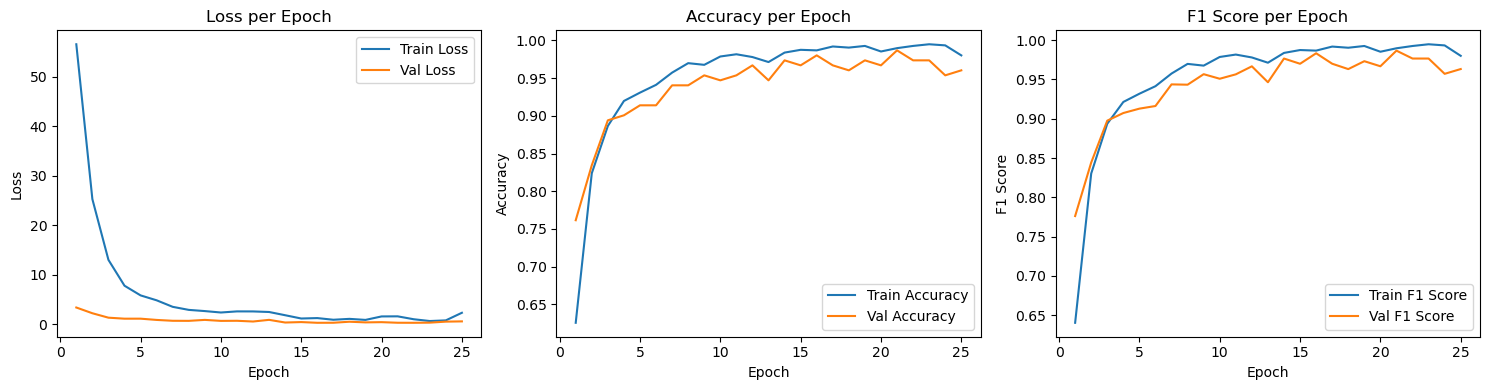

In [15]:
from sklearn.metrics import f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(num_classes=len(classes))
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
# class_weights = compute_class_weight('balanced', classes=np.arange(len(classes)), y=[label for _, label in tr_dl.dataset])
y = [int(label) for _, label in tr_dl.dataset]
class_weights = compute_class_weight('balanced', classes=np.arange(len(classes)), y=y)

weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

train_model(model, tr_dl, val_dl, criterion, optimizer, device, epochs=25)

Testing: 100%|██████████| 5/5 [00:00<00:00, 10.95it/s]


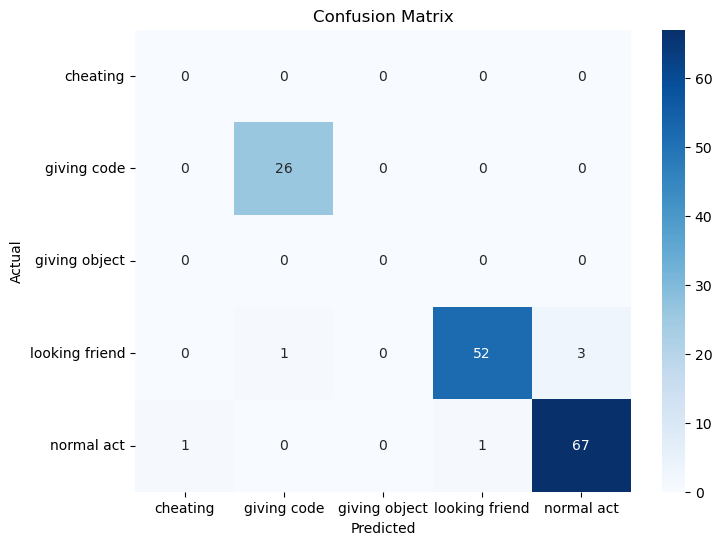


Classification Report:

                precision    recall  f1-score   support

      cheating       0.00      0.00      0.00         0
   giving code       0.96      1.00      0.98        26
 giving object       0.00      0.00      0.00         0
looking friend       0.98      0.93      0.95        56
    normal act       0.96      0.97      0.96        69

      accuracy                           0.96       151
     macro avg       0.58      0.58      0.58       151
  weighted avg       0.97      0.96      0.96       151



d:\Anaconda_folder\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Anaconda_folder\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Anaconda_folder\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Anaconda_folder\Lib\site-packages\sklearn\metrics\_class

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

# def evaluate_model(model, loader, class_dict, device):
#     model.eval()
#     all_preds, all_labels = [], []

#     with torch.no_grad():
#         for images, labels in tqdm(loader, desc="Testing"):
#             images = images.to(device)
#             labels = labels.to(device)

#             outputs = model(images)
#             preds = outputs.argmax(1)

#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     cm = confusion_matrix(all_labels, all_preds)
#     class_names = list(class_dict.keys())

#     plt.figure(figsize=(8,6))
#     sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
#     plt.xlabel("Predicted")
#     plt.ylabel("Actual")
#     plt.title("Confusion Matrix")
#     plt.show()

#     print("\nClassification Report:\n")
#     print(classification_report(all_labels, all_preds, target_names=class_names))

# evaluate_model(model, val_dl, classes, device)


from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

def evaluate_model(model, loader, class_dict, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_class_indices = list(class_dict.values())
    class_names = list(class_dict.keys())

    cm = confusion_matrix(all_labels, all_preds, labels=all_class_indices)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, labels=all_class_indices, target_names=class_names))

evaluate_model(model, val_dl, classes, device)


In [18]:
torch.save(model, "custom_cnn_full_model.pth")


In [19]:
import pandas as pd
from tqdm import tqdm

def predict_on_test(model, test_loader, class_dict, device, save_path="test_predictions.csv"):
    model.eval()
    results = []

    idx_to_class = {v: k for k, v in class_dict.items()}  

    with torch.no_grad():
        for images, paths in tqdm(test_loader, desc="Predicting"):
            images = images.to(device)

            outputs = model(images)
            preds = outputs.argmax(1).cpu().numpy()

            for path, pred in zip(paths, preds):
                results.append({
                    "image_path": path,
                    "predicted_class": idx_to_class[pred],
                    "predicted_index": int(pred)
                })

    df = pd.DataFrame(results)
    df.to_csv(save_path, index=False)
    print(f" Predictions saved to {save_path}")
    return df


In [20]:

predict_df = predict_on_test(model, ts_dl, classes, device)


Predicting: 100%|██████████| 496/496 [00:07<00:00, 70.69it/s]

 Predictions saved to test_predictions.csv


In [21]:
!pip install opencv-python


In [22]:
!pip install ultralytics


In [23]:
!pip install mediapipe


In [24]:
!pip install --user mediapipe


In [25]:
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (32, 32, 32)
        x = self.pool(F.relu(self.conv2(x)))  # (64, 16, 16)
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [26]:

import cv2
import torch
import numpy as np
from ultralytics import YOLO
import mediapipe as mp
from torchvision import transforms
from datetime import datetime
import pandas as pd

custom_cnn = CustomCNN(num_classes=5)
# custom_cnn.load_state_dict(torch.load("custom_cnn_full_model.pth", map_location=torch.device('cpu')))
# custom_cnn.eval()
custom_cnn = torch.load("custom_cnn_full_model.pth", map_location=torch.device('cpu'))
custom_cnn.eval()

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# phone_model = YOLO("yolov8n.pt") 
phone_model = YOLO("yolov8m.pt")

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(refine_landmarks=True)

class_labels = ['cheating', 'giving code', 'giving object', 'looking friend', 'normal act']  # Adjust if needed


100%|██████████| 49.7M/49.7M [00:20<00:00, 2.59MB/s]


In [27]:
import numpy
print(numpy.__version__)


1.26.4


In [28]:
def get_head_pose_direction(image, landmarks, img_w, img_h):
    try:
       
        image_points = np.array([
            [landmarks[1][0] * img_w, landmarks[1][1] * img_h],   
            [landmarks[152][0] * img_w, landmarks[152][1] * img_h], 
            [landmarks[263][0] * img_w, landmarks[263][1] * img_h], 
            [landmarks[33][0] * img_w, landmarks[33][1] * img_h],   
            [landmarks[287][0] * img_w, landmarks[287][1] * img_h], 
            [landmarks[57][0] * img_w, landmarks[57][1] * img_h]    
        ], dtype="double")

        model_points = np.array([
            [0.0, 0.0, 0.0],         
            [0.0, -63.6, -12.5],      
            [43.3, 32.7, -26.0],      
            [-43.3, 32.7, -26.0],    
            [28.9, -28.9, -24.1],     
            [-28.9, -28.9, -24.1]     
        ])

        focal_length = image.shape[1]
        center = (image.shape[1] / 2, image.shape[0] / 2)
        camera_matrix = np.array([
            [focal_length, 0, center[0]],
            [0, focal_length, center[1]],
            [0, 0, 1]
        ], dtype="double")

        dist_coeffs = np.zeros((4, 1))  

        success, rotation_vector, _ = cv2.solvePnP(
            model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE
        )

        if not success:
            return "Unknown"

        rmat, _ = cv2.Rodrigues(rotation_vector)
        proj_matrix = np.hstack((rmat, np.zeros((3, 1))))
        _, _, _, _, _, _, euler_angles = cv2.decomposeProjectionMatrix(proj_matrix)

        yaw = euler_angles[1][0]

        if yaw < -25:
            return "Looking Left"
        elif yaw > 25:
            return "Looking Right"
        else:
            return "Looking Forward"
    except:
        return "Unknown"


In [ ]:
### multi face head pose###

import time
import cv2
import torch
import pandas as pd
from datetime import datetime
import mediapipe as mp

log_columns = ['timestamp', 'face_id', 'face_detected', 'phone_detected', 'head_pose', 'predicted_action', 'alert']
log_data = []
last_log_time = time.time()

face_yaw_tracker = {}

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=5, min_detection_confidence=0.5)

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    h_img, w_img = frame.shape[:2]

    results = phone_model(frame_rgb)
    phone_detected = False
    phone_boxes = []
    for result in results:
        for box in result.boxes:
            cls_id = int(box.cls[0].item())
            label = phone_model.names[cls_id]
            if 'phone' in label.lower():
                phone_detected = True
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                phone_boxes.append((x1, y1, x2, y2))
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 255), 2)
                cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)
                # cv2.putText(frame, "ALERT: Phone Detected", (10, h_img - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                text_size = cv2.getTextSize(alert, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)[0]
                text_x = (w_img - text_size[0]) // 2
                cv2.putText(frame,"ALERT: Phone Detected" , (text_x, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    result = face_mesh.process(frame_rgb)
    hand_results = hands.process(frame_rgb)

    face_id = 1
    per_face_logs = []
    face_detected = False

    if result.multi_face_landmarks:
        face_detected = True
        for idx, face_landmarks in enumerate(result.multi_face_landmarks):
            x_coords = [lm.x * w_img for lm in face_landmarks.landmark]
            y_coords = [lm.y * h_img for lm in face_landmarks.landmark]
            x_min, x_max = int(min(x_coords)), int(max(x_coords))
            y_min, y_max = int(min(y_coords)), int(max(y_coords))

            landmarks = [(lm.x, lm.y, lm.z) for lm in face_landmarks.landmark]
            head_pose = get_head_pose_direction(frame, landmarks, w_img, h_img)

            face_key = f"face_{idx}"
            alert = ""
            if head_pose in ["Looking Left", "Looking Right"]:
                if face_key not in face_yaw_tracker:
                    face_yaw_tracker[face_key] = time.time()
                elif time.time() - face_yaw_tracker[face_key] >= 5:
                    alert = f"ALERT: {head_pose} for 5sec"
            else:
                face_yaw_tracker.pop(face_key, None)

            face_crop = frame[y_min:y_max, x_min:x_max]
            action_label = "Unknown"
            if face_crop.size != 0:
                try:
                    resized_face = cv2.resize(face_crop, (64, 64))
                    input_tensor = transform(resized_face).unsqueeze(0)
                    with torch.no_grad():
                        output = custom_cnn(input_tensor)
                        pred_idx = torch.argmax(output, dim=1).item()
                        action_label = class_labels[pred_idx]
                except:
                    pass

           
            suspicious = False
            
            
            if hand_results.multi_hand_landmarks:
                for hand_landmarks in hand_results.multi_hand_landmarks:
                    wrist = hand_landmarks.landmark[0]
                    middle_finger_tip = hand_landmarks.landmark[12]
                    hand_span = abs(middle_finger_tip.x - wrist.x)
                    if hand_span > 0.2:
                        action_label = "giving code"
                        suspicious = True
                    else:
                        action_label = "giving object"
                        suspicious = True
            
          
            for (px1, py1, px2, py2) in phone_boxes:
                
                if not (px2 < x_min or px1 > x_max or py2 < y_min or py1 > y_max):
                    action_label = "cheating"
                    suspicious = True
                    break
            
            if head_pose in ["Looking Left", "Looking Right"]:
                if face_key not in face_yaw_tracker:
                    face_yaw_tracker[face_key] = time.time()
                elif time.time() - face_yaw_tracker[face_key] >= 3:
                    action_label = "looking friend"
                    suspicious = True
            else:
                face_yaw_tracker.pop(face_key, None)

            if not suspicious:
                action_label = "normal act"

            box_color = (255, 0, 0) if face_id == 1 else (255, 0, 0)
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), box_color, 2)
            cv2.putText(frame, f"Face {face_id}", (x_min, y_min - 45), cv2.FONT_HERSHEY_SIMPLEX, 0.6, box_color, 2)
            cv2.putText(frame, head_pose, (x_min, y_min - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 250, 0), 2)
            cv2.putText(frame, action_label, (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 100, 255), 2)
            if alert:
                # cv2.putText(frame, alert, (x_min, y_max + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
                text_size = cv2.getTextSize(alert, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)[0]
                text_x = (w_img - text_size[0]) // 2
                cv2.putText(frame, alert, (text_x, 55), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            per_face_logs.append([face_id, face_detected, phone_detected, head_pose, action_label, alert])
            face_id += 1


    total_faces = face_id - 1
    if total_faces > 1:
        cv2.putText(frame, f"WARNING: Multiple Faces Detected ({total_faces})", (10, h_img - 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 140, 255), 2)
        
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        log_data.append([timestamp, "ALL", True, phone_detected, "Multiple Faces", "-", "ALERT: More than one face"])
    
    current_time = time.time()
    if current_time - last_log_time >= 5:
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        for row in per_face_logs:
            log_data.append([timestamp] + row)
        pd.DataFrame(log_data, columns=log_columns).to_csv("log.csv", index=False)
        last_log_time = current_time

    cv2.putText(frame, f"Total Faces: {face_id - 1}", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    cv2.putText(frame, f"Phone: {'Yes' if phone_detected else 'No'}", (10, 45), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

    cv2.namedWindow("Exam Monitoring", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Exam Monitoring", 600, 480)  
    cv2.imshow("Exam Monitoring", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [ ]:
### multi face head pose###

###WITH SOUND###

import time
import cv2
import torch
import pandas as pd
from datetime import datetime
import mediapipe as mp
import winsound  

log_columns = ['timestamp', 'face_id', 'face_detected', 'phone_detected', 'head_pose', 'predicted_action', 'alert']
log_data = []
last_log_time = time.time()
last_beep_time = 0  
beep_interval = 5  


face_yaw_tracker = {}

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=5, min_detection_confidence=0.5)

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    h_img, w_img = frame.shape[:2]

    results = phone_model(frame_rgb)
    phone_detected = False
    phone_boxes = []
    phone_alert = ""
    for result in results:
        for box in result.boxes:
            cls_id = int(box.cls[0].item())
            label = phone_model.names[cls_id]
            if 'phone' in label.lower():
                phone_detected = True
                phone_alert = "ALERT: Phone Detected"
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                phone_boxes.append((x1, y1, x2, y2))
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 255), 2)
                cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)
                text_size = cv2.getTextSize(phone_alert, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)[0]
                text_x = (w_img - text_size[0]) // 2
                cv2.putText(frame, phone_alert, (text_x, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                if time.time() - last_beep_time >= beep_interval:
                    winsound.Beep(1000, 600)
                    last_beep_time = time.time()

    result = face_mesh.process(frame_rgb)
    hand_results = hands.process(frame_rgb)

    face_id = 1
    per_face_logs = []
    face_detected = False

    if result.multi_face_landmarks:
        face_detected = True
        for idx, face_landmarks in enumerate(result.multi_face_landmarks):
            x_coords = [lm.x * w_img for lm in face_landmarks.landmark]
            y_coords = [lm.y * h_img for lm in face_landmarks.landmark]
            x_min, x_max = int(min(x_coords)), int(max(x_coords))
            y_min, y_max = int(min(y_coords)), int(max(y_coords))

            landmarks = [(lm.x, lm.y, lm.z) for lm in face_landmarks.landmark]
            head_pose = get_head_pose_direction(frame, landmarks, w_img, h_img)

            face_key = f"face_{idx}"
            alert = ""
            if head_pose in ["Looking Left", "Looking Right"]:
                if face_key not in face_yaw_tracker:
                    face_yaw_tracker[face_key] = time.time()
                elif time.time() - face_yaw_tracker[face_key] >= 5:
                    alert = f"ALERT: {head_pose} for 5sec"
                    if time.time() - last_beep_time >= beep_interval:
                        winsound.Beep(1000, 600)
                        last_beep_time = time.time()
            else:
                face_yaw_tracker.pop(face_key, None)

            face_crop = frame[y_min:y_max, x_min:x_max]
            action_label = "Unknown"
            if face_crop.size != 0:
                try:
                    resized_face = cv2.resize(face_crop, (64, 64))
                    input_tensor = transform(resized_face).unsqueeze(0)
                    with torch.no_grad():
                        output = custom_cnn(input_tensor)
                        pred_idx = torch.argmax(output, dim=1).item()
                        action_label = class_labels[pred_idx]
                except:
                    pass

            suspicious = False

            if hand_results.multi_hand_landmarks:
                for hand_landmarks in hand_results.multi_hand_landmarks:
                    wrist = hand_landmarks.landmark[0]
                    middle_finger_tip = hand_landmarks.landmark[12]
                    hand_span = abs(middle_finger_tip.x - wrist.x)
                    if hand_span > 0.2:
                        action_label = "giving code"
                        suspicious = True
                    else:
                        action_label = "giving object"
                        suspicious = True

            for (px1, py1, px2, py2) in phone_boxes:
                if not (px2 < x_min or px1 > x_max or py2 < y_min or py1 > y_max):
                    action_label = "cheating"
                    suspicious = True
                    break

            if head_pose in ["Looking Left", "Looking Right"]:
                if face_key not in face_yaw_tracker:
                    face_yaw_tracker[face_key] = time.time()
                elif time.time() - face_yaw_tracker[face_key] >= 3:
                    action_label = "looking friend"
                    suspicious = True
            else:
                face_yaw_tracker.pop(face_key, None)

            if not suspicious:
                action_label = "normal act"

            box_color = (255, 0, 0)
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), box_color, 2)
            cv2.putText(frame, f"Face {face_id}", (x_min, y_min - 45), cv2.FONT_HERSHEY_SIMPLEX, 0.6, box_color, 2)
            cv2.putText(frame, head_pose, (x_min, y_min - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 250, 0), 2)
            cv2.putText(frame, action_label, (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0, 100, 255), 2)
            if alert:
                text_size = cv2.getTextSize(alert, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)[0]
                text_x = (w_img - text_size[0]) // 2
                cv2.putText(frame, alert, (text_x, 55), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            full_alert = alert if alert else phone_alert
            per_face_logs.append([face_id, face_detected, phone_detected, head_pose, action_label, full_alert])
            face_id += 1

    total_faces = face_id - 1
    if total_faces > 1:
        multi_alert = f"WARNING: Multiple Faces Detected ({total_faces})"
        cv2.putText(frame, multi_alert, (10, h_img - 50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 140, 255), 2)
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        log_data.append([timestamp, "ALL", True, phone_detected, "Multiple Faces", "-", "ALERT: More than one face"])
        if time.time() - last_beep_time >= beep_interval:
            winsound.Beep(1000, 600)
            last_beep_time = time.time()

    current_time = time.time()
    if current_time - last_log_time >= 5:
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        for row in per_face_logs:
            log_data.append([timestamp] + row)
        pd.DataFrame(log_data, columns=log_columns).to_csv("log.csv", index=False)
        last_log_time = current_time

    cv2.putText(frame, f"Total Faces: {face_id - 1}", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    cv2.putText(frame, f"Phone: {'Yes' if phone_detected else 'No'}", (10, 45), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

    cv2.namedWindow("Exam Monitoring", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Exam Monitoring", 800, 600)
    cv2.imshow("Exam Monitoring", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


In [32]:

### WITH ALERT 2 OPTIMIZED FOR SINGLE FACE###
import time
import cv2
import torch
import pandas as pd
from datetime import datetime

log_columns = ['timestamp', 'face_id', 'face_detected', 'phone_detected', 'head_pose', 'predicted_action', 'alert']
log_data = []
last_log_time = time.time()

face_yaw_tracker = {}
face_alert_triggered = {}

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    h_img, w_img = frame.shape[:2]
    alert = ""
    phone_detected = False
    per_face_logs = []
    phone_boxes = []

    results = phone_model(frame_rgb)
    for result in results:
        for box in result.boxes:
            cls_id = int(box.cls[0].item())
            label = phone_model.names[cls_id]
            if 'phone' in label.lower():
                phone_detected = True
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                phone_boxes.append((x1, y1, x2, y2))
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 255), 2)
                cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 1)
                # cv2.putText(frame, "ALERT: Phone Detected", (10, h_img - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                text_x = (w_img - text_size[0]) // 2
                cv2.putText(frame,"ALERT: Phone Detected" , (text_x, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                alert = "Phone Detected"

    result = face_mesh.process(frame_rgb)
    hand_results = hands.process(frame_rgb)
    face_id = 1

    if result.multi_face_landmarks:
        face_count = len(result.multi_face_landmarks)
        for idx, face_landmarks in enumerate(result.multi_face_landmarks):
            x_coords = [lm.x * w_img for lm in face_landmarks.landmark]
            y_coords = [lm.y * h_img for lm in face_landmarks.landmark]
            x_min, x_max = int(min(x_coords)), int(max(x_coords))
            y_min, y_max = int(min(y_coords)), int(max(y_coords))
            color = (255, 0, 0)
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), color, 2)
            cv2.putText(frame, f"Face {face_id}", (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

            if idx == 0:
                
                landmarks = [(lm.x, lm.y, lm.z) for lm in face_landmarks.landmark]
                head_pose = get_head_pose_direction(frame, landmarks, w_img, h_img)
                face_key = f"face_{idx}"

                if head_pose in ["Looking Left", "Looking Right"]:
                    if face_key not in face_yaw_tracker:
                        face_yaw_tracker[face_key] = time.time()
                        face_alert_triggered[face_key] = False
                    else:
                        duration = time.time() - face_yaw_tracker[face_key]
                        if duration >= 5:
                            alert = f"ALERT: {head_pose} for 5s"
                            face_alert_triggered[face_key] = True
                else:
                    face_yaw_tracker.pop(face_key, None)
                    face_alert_triggered.pop(face_key, None)

                face_crop = frame[y_min:y_max, x_min:x_max]
                action_label = "Unknown"
                suspicious = False

                if face_crop.size != 0:
                    try:
                        resized_face = cv2.resize(face_crop, (64, 64))
                        input_tensor = transform(resized_face).unsqueeze(0)
                        with torch.no_grad():
                            output = custom_cnn(input_tensor)
                            pred_idx = torch.argmax(output, dim=1).item()
                            action_label = class_labels[pred_idx]
                    except:
                        pass

                if hand_results.multi_hand_landmarks:
                    for hand_landmarks in hand_results.multi_hand_landmarks:
                        wrist = hand_landmarks.landmark[0]
                        middle_finger_tip = hand_landmarks.landmark[12]
                        hand_span = abs(middle_finger_tip.x - wrist.x)
                        if hand_span > 0.2:
                            action_label = "giving code"
                            suspicious = True
                        else:
                            action_label = "giving object"
                            suspicious = True

                for (px1, py1, px2, py2) in phone_boxes:
                    if not (px2 < x_min or px1 > x_max or py2 < y_min or py1 > y_max):
                        action_label = "cheating"
                        suspicious = True
                        break

                if face_count > 1:
                    action_label = "cheating"
                    suspicious = True

                if head_pose in ["Looking Left", "Looking Right"]:
                    if face_key not in face_yaw_tracker:
                        face_yaw_tracker[face_key] = time.time()
                    elif time.time() - face_yaw_tracker[face_key] >= 3:
                        action_label = "looking friend"
                        suspicious = True
                else:
                    face_yaw_tracker.pop(face_key, None)

                if not suspicious:
                    action_label = "normal act"

                
                cv2.putText(frame, action_label, (x_min, y_min - 45), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0, 140, 255), 2)
                cv2.putText(frame, head_pose, (x_min, y_min - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
                per_face_logs.append([face_id, True, phone_detected, head_pose, action_label, alert])
            else:
                per_face_logs.append([face_id, True, phone_detected, "Not Processed", "Not Processed", ""])

            face_id += 1

        if face_count > 1:
            action_label = "cheating"
            cv2.putText(frame, f"ALERT: Multiple Faces Detected ({face_count})", (10, h_img - 50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 140, 255), 2)
            

    current_time = time.time()
    if current_time - last_log_time >= 5:
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        df = pd.DataFrame([ [timestamp] + row for row in per_face_logs ], columns=log_columns)
        df.to_csv("log.csv", mode='a', header=not pd.io.common.file_exists("log.csv"), index=False)
        last_log_time = current_time

    cv2.putText(frame, f"Faces: {face_id - 1}", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    cv2.putText(frame, f"Phone: {'Yes' if phone_detected else 'No'}", (10, 45), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
    # text_x = (w_img - text_size[0]) // 2
    # cv2.putText(frame,"ALERT: Phone Detected" , (text_x, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    if alert and "5s" in alert:
        # cv2.putText(frame, alert, (10, h_img - 80), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
         text_size = cv2.getTextSize(alert, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2)[0]
         text_x = (w_img - text_size[0]) // 2
         cv2.putText(frame, alert, (text_x, 55), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    cv2.namedWindow("Exam Monitoring (Optimized)", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Exam Monitoring (Optimized)", 600, 480)  
    cv2.imshow("Exam Monitoring (Optimized)", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



0: 480x640 1 person, 1 kite, 352.7ms
Speed: 4.1ms preprocess, 352.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 kites, 293.2ms
Speed: 1.3ms preprocess, 293.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 kites, 1 cell phone, 321.1ms
Speed: 1.3ms preprocess, 321.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 tie, 2 kites, 319.6ms
Speed: 1.2ms preprocess, 319.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 2 kites, 284.0ms
Speed: 1.4ms preprocess, 284.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 tie, 2 kites, 277.1ms
Speed: 1.1ms preprocess, 277.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bird, 2 kites, 294.4ms
Speed: 1.1ms preprocess, 294.4ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 48